In [1]:
# STEP 1 - Installing Necessary Libraries

!pip install pmdarima
!pip install prophet
!pip install keras
!pip install yfinance --upgrade --no-cache-dir

In [2]:
# STEP 2 - Importing & Cleaning the Dataset

from google.colab import files
import pandas as pd
# Upload the dataset
uploaded = files.upload()
# Load and clean the dataset
df = pd.read_csv("Yahoo Finance Stock Data.csv")
# Convert date with UTC handling to avoid timezone warnings
df.columns = df.columns.str.strip()
df["Date"] = pd.to_datetime(df["Date"], utc=True)
df = df.sort_values(by=["Company", "Date"]).reset_index(drop=True)
# Save cleaned dataset for further use
df.to_csv("Cleaned Yahoo Finance Stock Data.csv", index=False)
df.head(5)

Saving Yahoo Finance Stock Data.csv to Yahoo Finance Stock Data.csv


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 05:00:00+00:00,70.472351,71.517441,69.957722,71.184914,3838000,0.0,0.0,ABBV
1,2018-12-03 05:00:00+00:00,74.676465,74.993160,73.488862,74.153923,6673900,0.0,0.0,ABBV
2,2018-12-11 05:00:00+00:00,70.163581,70.812804,68.611781,69.807297,5098100,0.0,0.0,ABBV
3,2018-12-13 05:00:00+00:00,70.757391,71.248263,69.173920,69.443108,4078600,0.0,0.0,ABBV
4,2018-12-14 05:00:00+00:00,68.722616,69.007641,67.360830,67.780449,5461600,0.0,0.0,ABBV


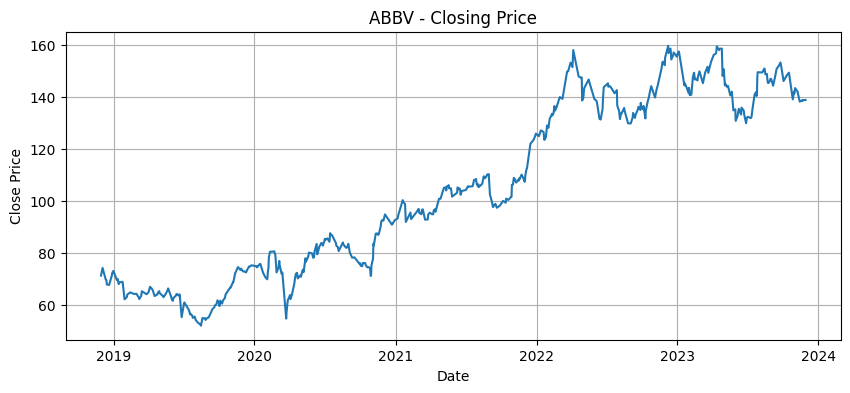

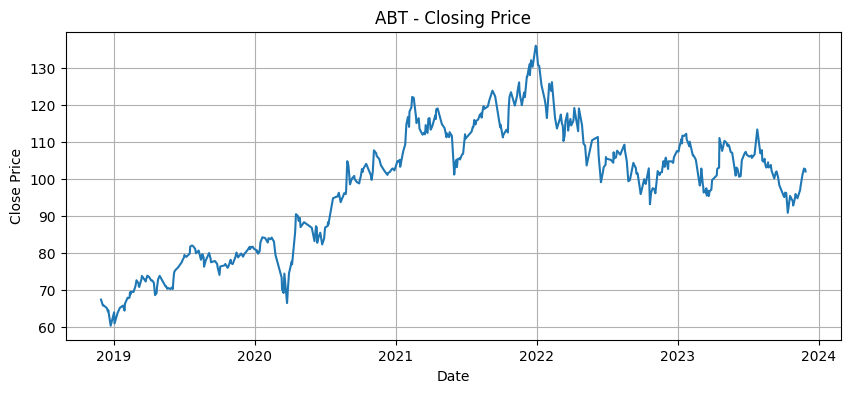

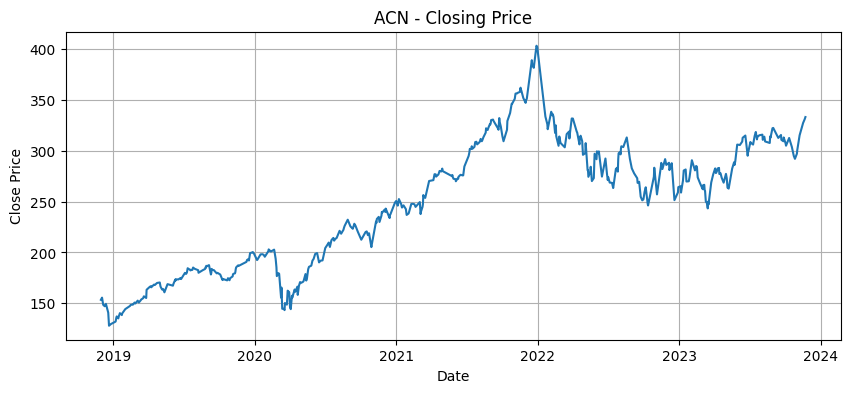

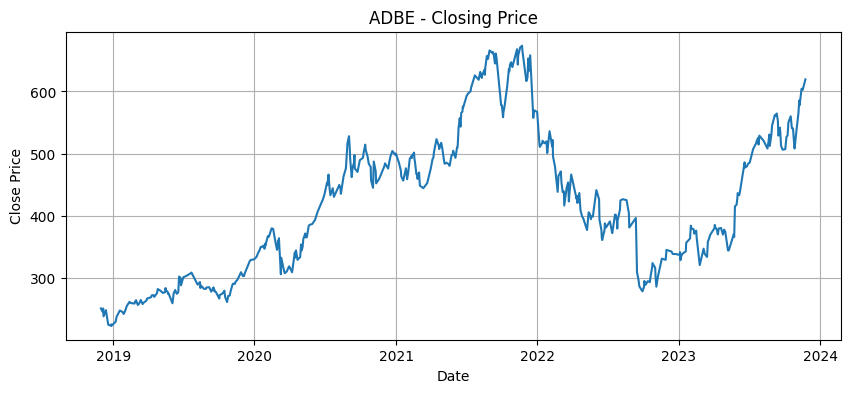

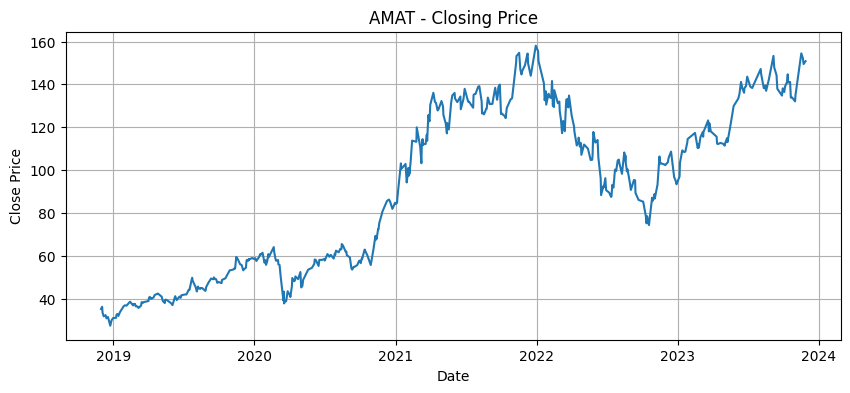

In [3]:
# STEP 3 - Visualizing the Data

import matplotlib.pyplot as plt
# Limit to first 5 companies only
companies = df["Company"].unique()[:5]
for company in companies:
    company_df = df[df["Company"] == company]
    plt.figure(figsize=(10, 4))
    plt.plot(company_df["Date"], company_df["Close"])
    plt.title(f"{company} - Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid()
    plt.show()

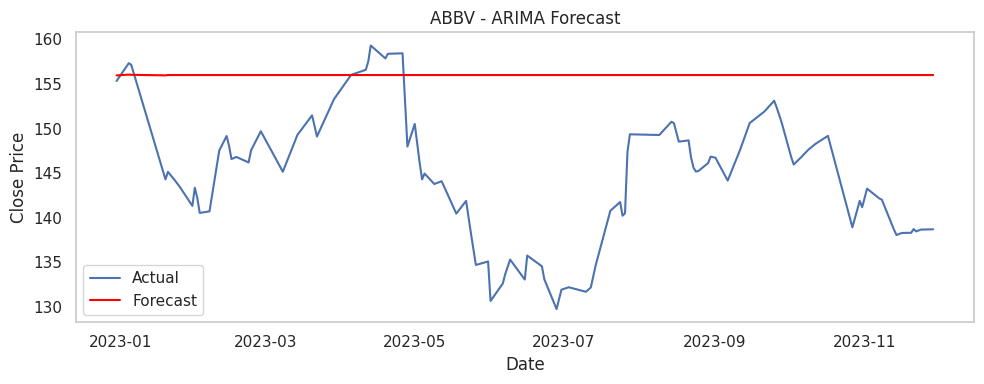

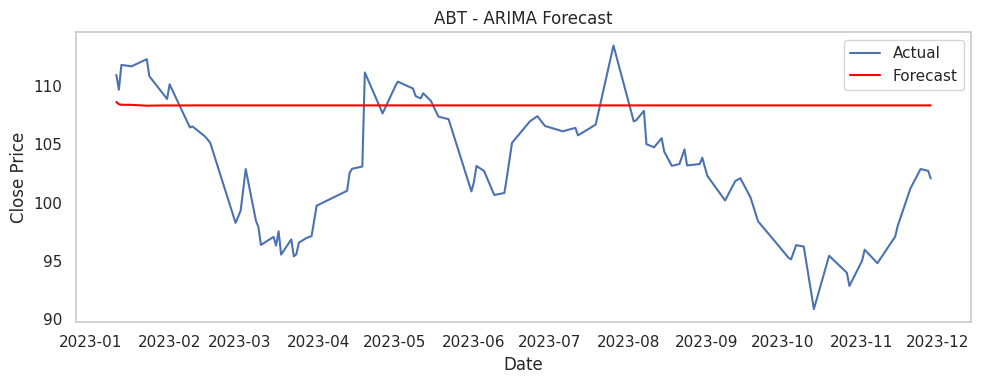

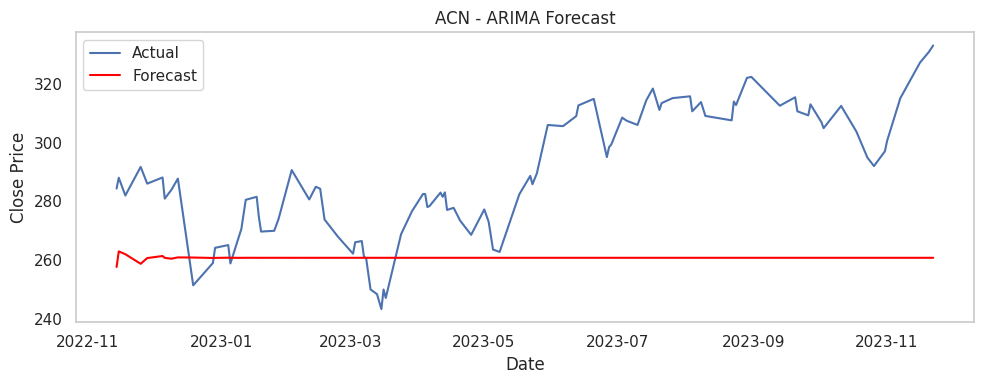

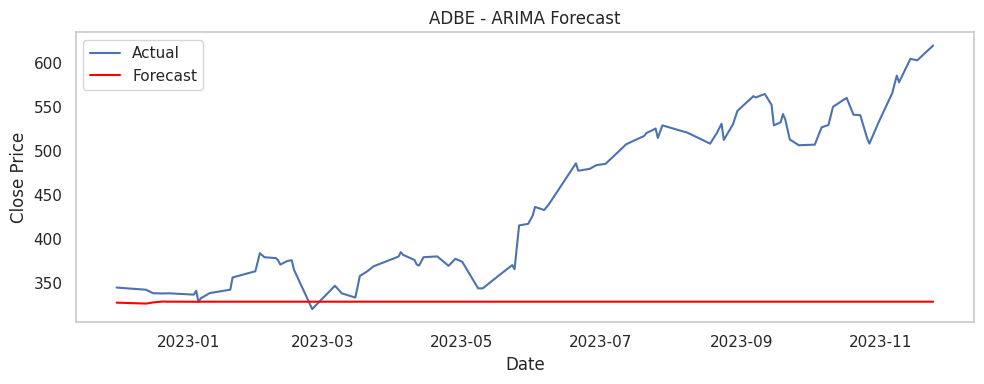

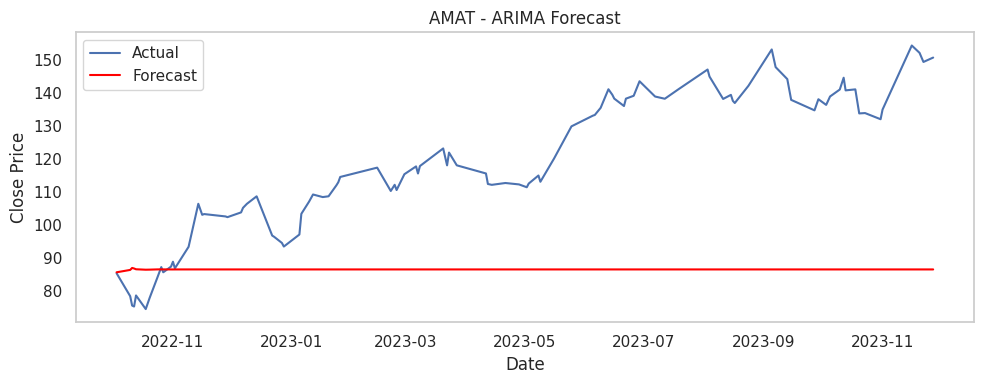

ARIMA completed for 100 companies


In [25]:
# STEP 4 - ARIMA Model Forecasting

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
results = []
companies = df["Company"].unique()[:3000]
plot_limit = 5
plot_count = 0
FALLBACK_MSE = 1e12  # Large value for failed models
for company in companies:
    try:
        company_df = df[df["Company"] == company].copy()
        company_df["Date"] = pd.to_datetime(company_df["Date"])
        company_df = company_df.sort_values("Date")
        ts = company_df["Close"].values
        split = int(0.8 * len(ts))
        train, test = ts[:split], ts[split:]
        # If data is too short, record fallback
        if len(train) < 30 or len(test) < 5:
            results.append((company, "ARIMA", FALLBACK_MSE))
            continue
        # Fit ARIMA model
        model = ARIMA(train, order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        results.append((company, "ARIMA", mse))
        # Optional plotting for first few companies
        if plot_count < plot_limit:
            plt.figure(figsize=(10, 4))
            plt.plot(company_df["Date"][split:], test, label="Actual")
            plt.plot(company_df["Date"][split:], forecast, label="Forecast", color="red")
            plt.title(f"{company} - ARIMA Forecast")
            plt.xlabel("Date")
            plt.ylabel("Close Price")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()
            plot_count += 1
    except Exception as e:
        results.append((company, "ARIMA", FALLBACK_MSE))
        print(f"Error with {company}: {e}")
print(f"ARIMA completed for {len(results)} companies")

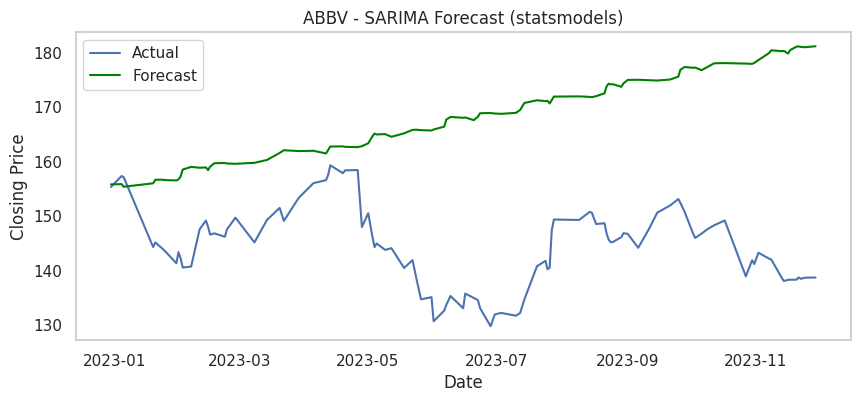

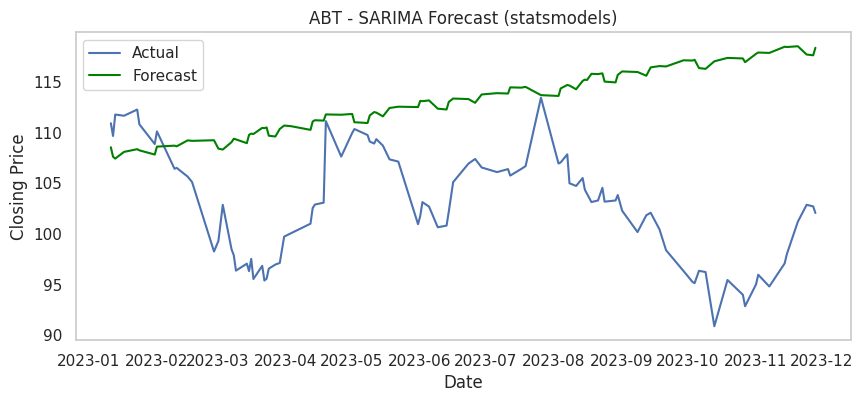

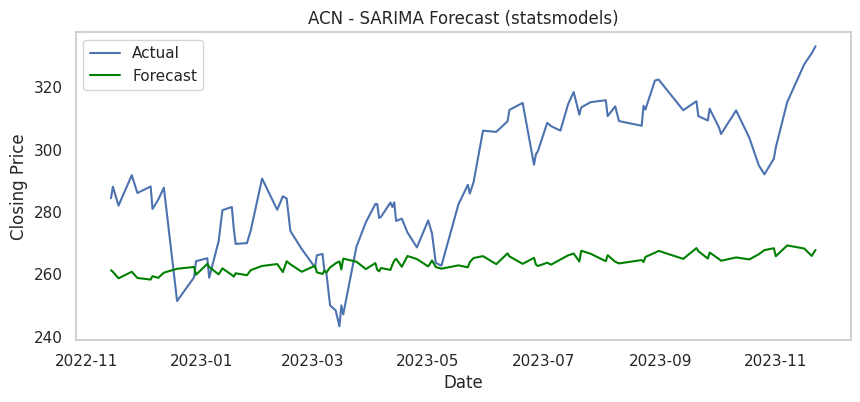

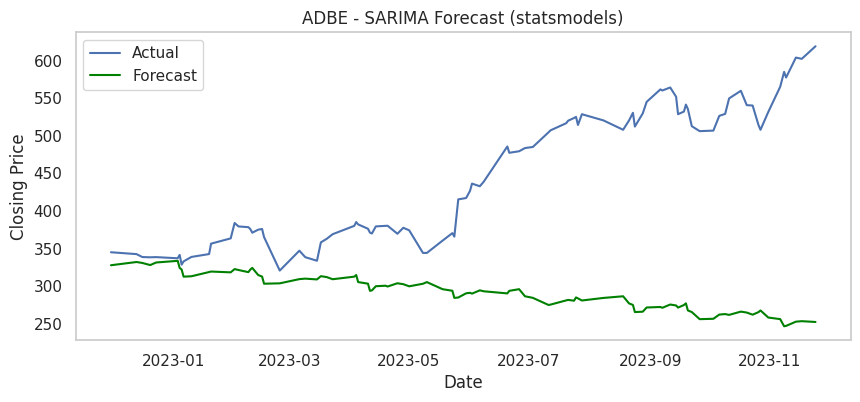

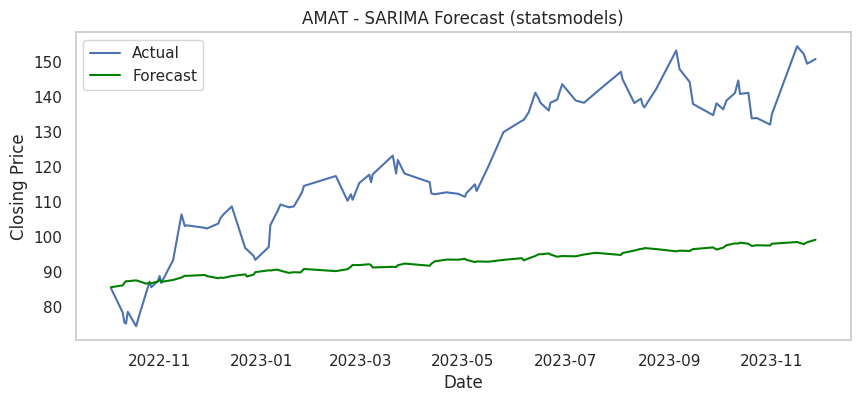

SARIMA completed for 100 companies


In [26]:
# STEP 5 - SARIMA Model Forecasting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
results_sarima_statsmodels = []
companies = df["Company"].unique()[:3000]
plot_limit = 5
plot_count = 0
FALLBACK_MSE = 1e12  # Large MSE for failed forecasts
for company in companies:
    try:
        company_df = df[df["Company"] == company].copy()
        company_df["Date"] = pd.to_datetime(company_df["Date"])
        company_df = company_df.sort_values("Date")
        ts = company_df["Close"].values
        split = int(0.8 * len(ts))
        train, test = ts[:split], ts[split:]
        # If data is too short, record fallback instead of skipping
        if len(train) < 30 or len(test) < 5:
            results_sarima_statsmodels.append((company, "SARIMA", FALLBACK_MSE))
            continue
        # Fit SARIMA model
        model = SARIMAX(
            train,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test))
        mse = mean_squared_error(test, forecast)
        results_sarima_statsmodels.append((company, "SARIMA", mse))
        # Optional plotting for first few companies
        if plot_count < plot_limit:
            plt.figure(figsize=(10, 4))
            plt.plot(company_df["Date"][split:], test, label="Actual")
            plt.plot(company_df["Date"][split:], forecast, label="Forecast", color="green")
            plt.title(f"{company} - SARIMA Forecast (statsmodels)")
            plt.xlabel("Date")
            plt.ylabel("Closing Price")
            plt.legend()
            plt.grid()
            plt.show()
            plot_count += 1
    except Exception as e:
        results_sarima_statsmodels.append((company, "SARIMA", FALLBACK_MSE))
        print(f"Error with {company}: {e}")
print(f"SARIMA completed for {len(results_sarima_statsmodels)} companies")

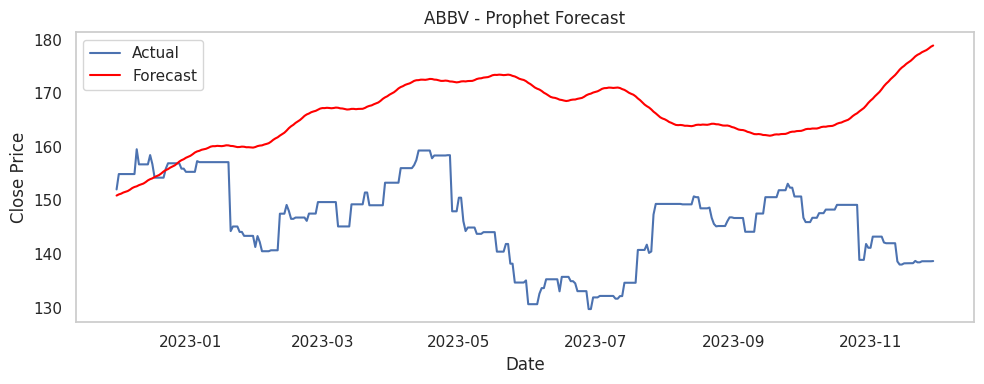

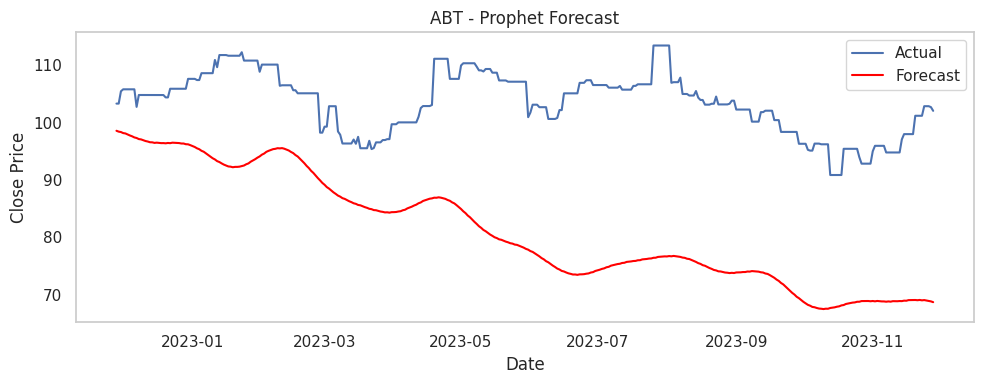

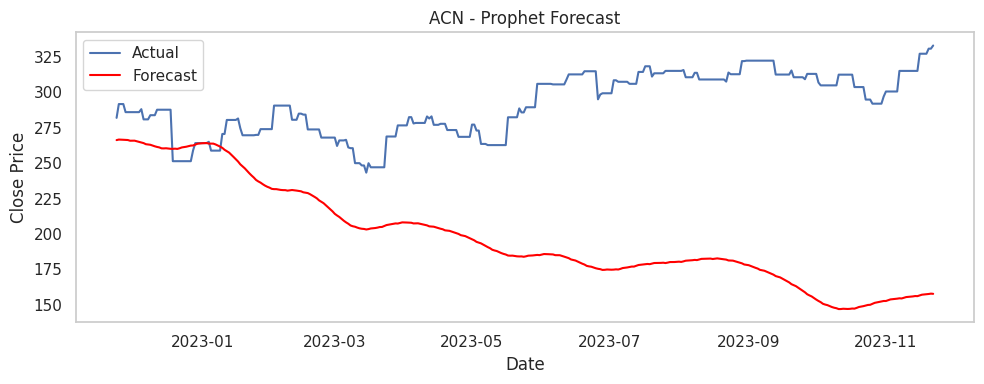

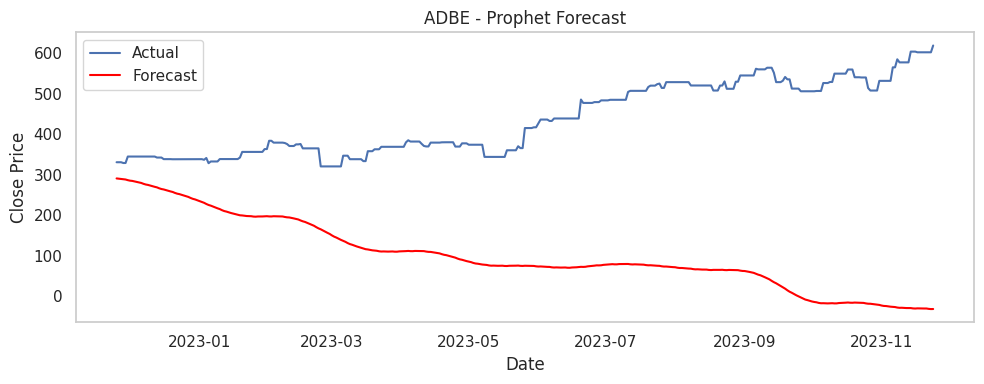

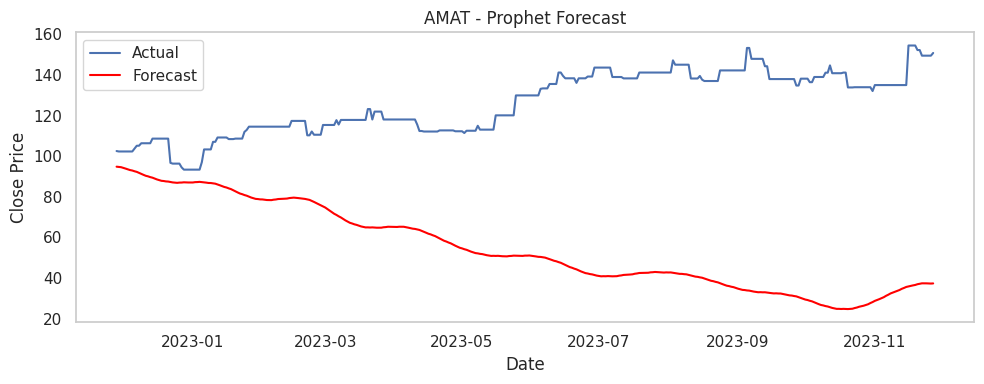

Prophet completed for 100 companies


In [27]:
# STEP 6 - Prophet Model Forecasting

# STEP 6 - Prophet Model Forecasting

import logging
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
# Suppress warnings and verbose logs
warnings.filterwarnings("ignore")
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
logging.getLogger("prophet").setLevel(logging.WARNING)
results_prophet = []
companies = df["Company"].unique()[:3000]
plot_limit = 5
plot_count = 0
FALLBACK_MSE = 1e12  # Large MSE for failed forecasts
for company in companies:
    try:
        # Step 1: Prepare company data
        company_df = df[df["Company"] == company].copy()
        company_df["Date"] = pd.to_datetime(company_df["Date"], utc=True).dt.tz_localize(None)
        company_df = company_df.sort_values("Date")
        # Step 2: Format for Prophet
        prophet_df = company_df[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
        prophet_df = prophet_df.set_index("ds").resample("D").mean().ffill().reset_index()
        # Step 3: Data check — if too short, record fallback
        if len(prophet_df) < 50:
            results_prophet.append((company, "Prophet", FALLBACK_MSE))
            continue
        # Step 4: Train-test split
        split = int(0.8 * len(prophet_df))
        train = prophet_df.iloc[:split]
        test = prophet_df.iloc[split:]
        # Step 5: Fit Prophet model
        model = Prophet(daily_seasonality=True)
        model.fit(train)
        # Step 6: Forecast
        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)
        y_pred = forecast.iloc[-len(test):]["yhat"].values
        y_true = test["y"].values
        mse = mean_squared_error(y_true, y_pred)
        results_prophet.append((company, "Prophet", mse))
        # Step 7: Plot only for first N companies
        if plot_count < plot_limit:
            plt.figure(figsize=(10, 4))
            plt.plot(test["ds"], y_true, label="Actual")
            plt.plot(test["ds"], y_pred, label="Forecast", color="red")
            plt.title(f"{company} - Prophet Forecast")
            plt.xlabel("Date")
            plt.ylabel("Close Price")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()
            plot_count += 1
    except Exception as e:
        results_prophet.append((company, "Prophet", FALLBACK_MSE))
        print(f"Error with {company}: {e}")
print(f"Prophet completed for {len(results_prophet)} companies")

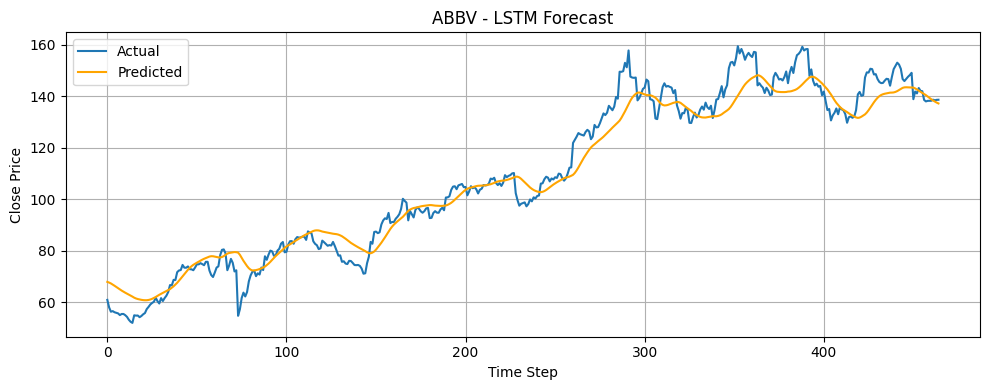

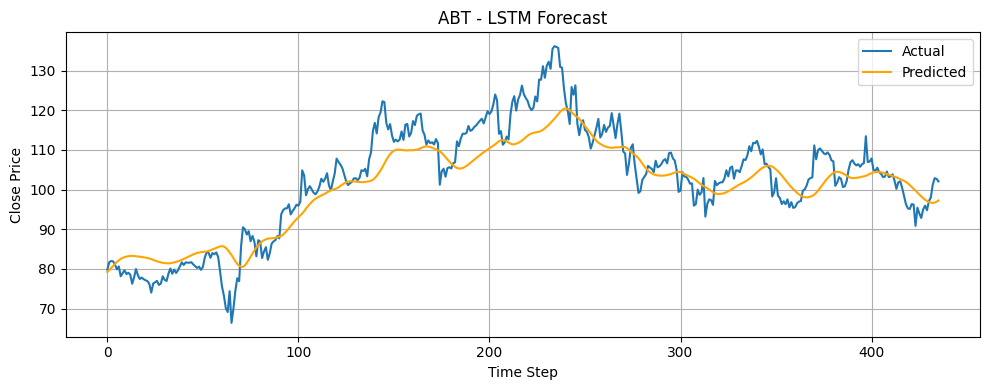

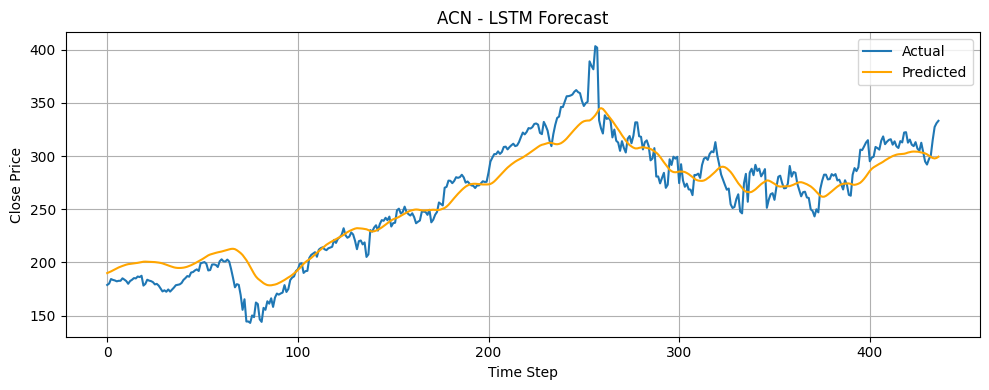

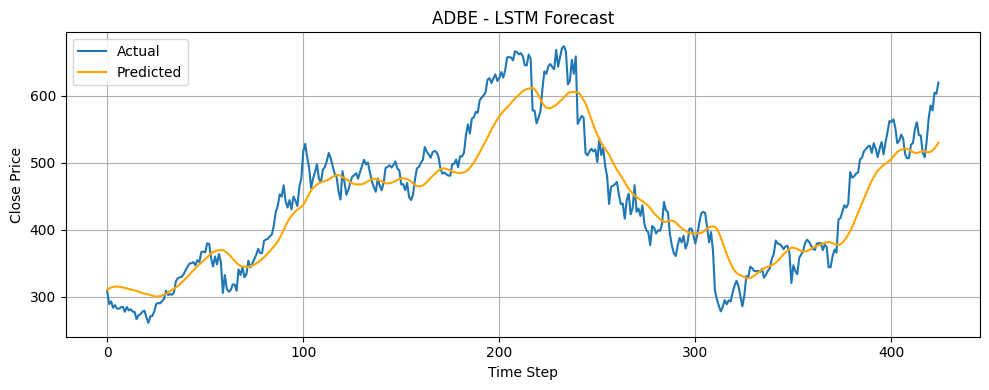

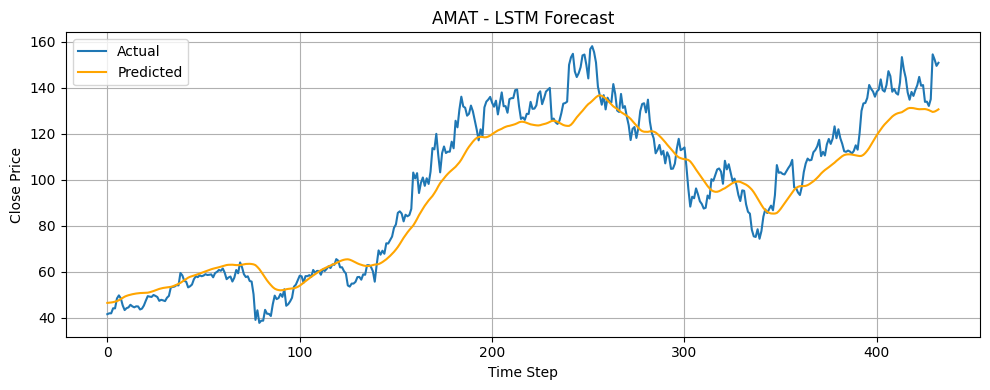

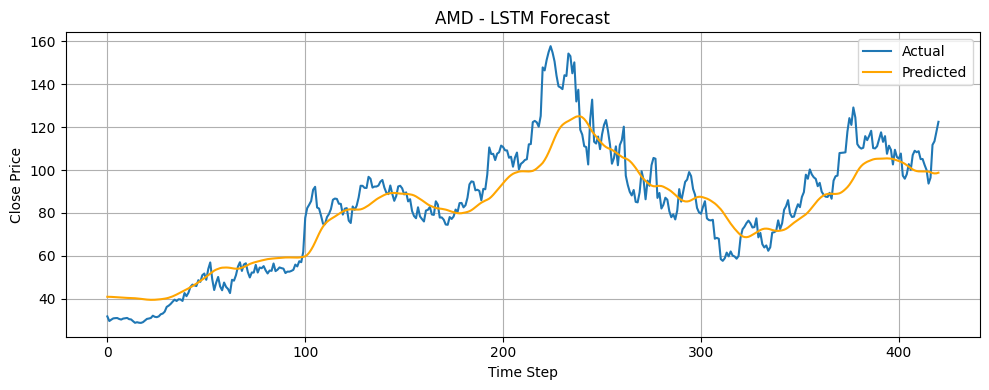

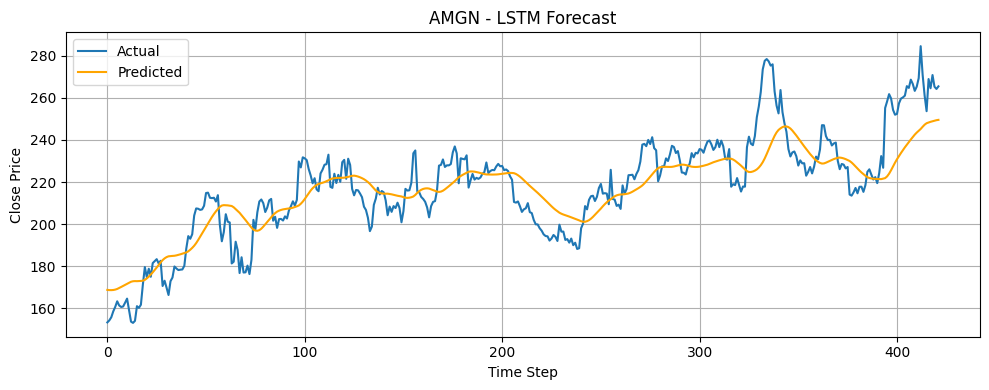

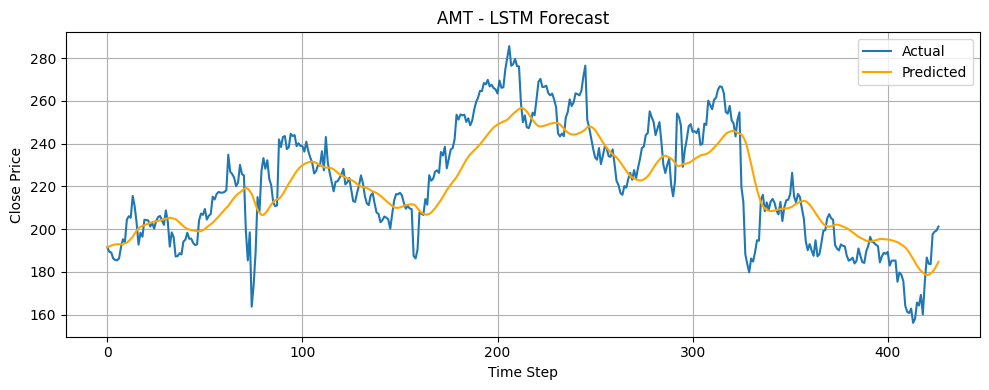

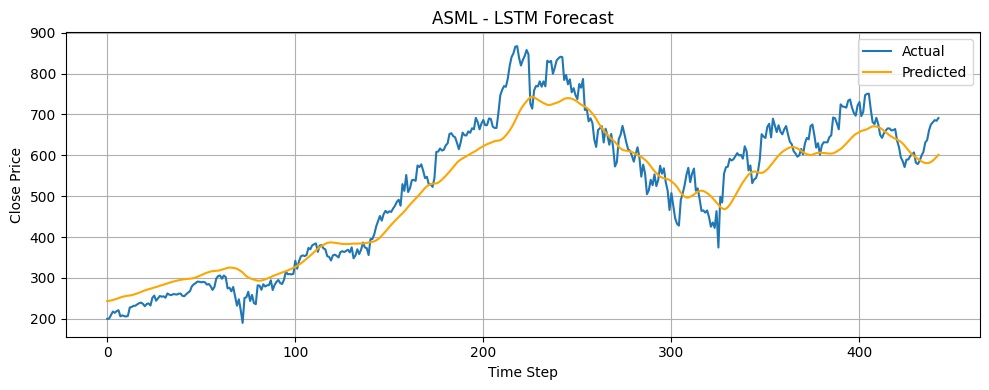

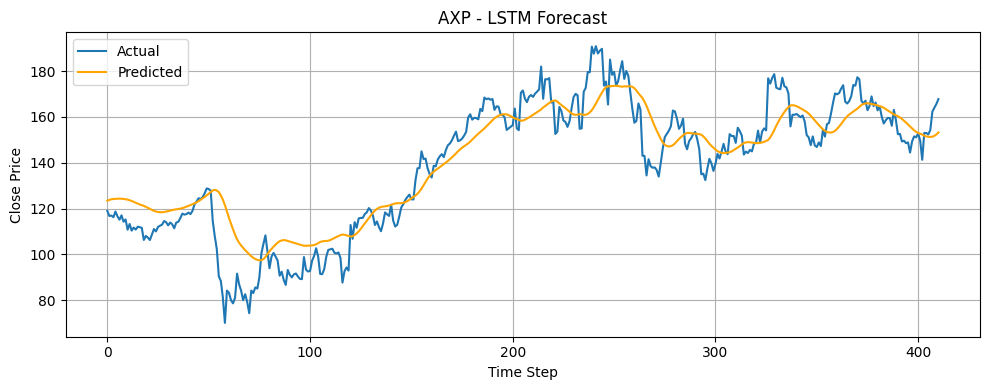

LSTM completed for 100 companies


In [9]:
# STEP 7 - LSTM Model Forecasting

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
results_lstm = []
companies = df["Company"].unique()[:3000]
plot_limit = 10
plot_count = 0
FALLBACK_MSE = 1e12  # Large value for failed forecasts
def create_lstm_data(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
for company in companies:
    try:
        company_df = df[df["Company"] == company].copy()
        company_df = company_df.sort_values("Date")
        close = company_df["Close"].values.reshape(-1, 1)
        # If short series, record fallback and skip training
        if len(close) < 100:
            results_lstm.append((company, "LSTM", FALLBACK_MSE))
            continue
        # Normalize and create sequences
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(close)
        X, y = create_lstm_data(scaled)
        if len(X) == 0:
            results_lstm.append((company, "LSTM", FALLBACK_MSE))
            continue
        X = X.reshape(X.shape[0], X.shape[1], 1)
        # Build and train model
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X, y, epochs=3, batch_size=32, verbose=0)
        # Predict and inverse scale
        predictions = model.predict(X, verbose=0)
        predictions = scaler.inverse_transform(predictions)
        y_actual = scaler.inverse_transform(y.reshape(-1, 1))
        mse = mean_squared_error(y_actual, predictions)
        results_lstm.append((company, "LSTM", mse))
        # Plot only first N companies
        if plot_count < plot_limit:
            plt.figure(figsize=(10, 4))
            plt.plot(y_actual, label="Actual")
            plt.plot(predictions, label="Predicted", color="orange")
            plt.title(f"{company} - LSTM Forecast")
            plt.xlabel("Time Step")
            plt.ylabel("Close Price")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()
            plot_count += 1
    except Exception as e:
        results_lstm.append((company, "LSTM", FALLBACK_MSE))
        print(f"Skipping {company} due to LSTM error: {e}")
print(f"LSTM completed for {len(results_lstm)} companies")

Saved full results with 400 rows


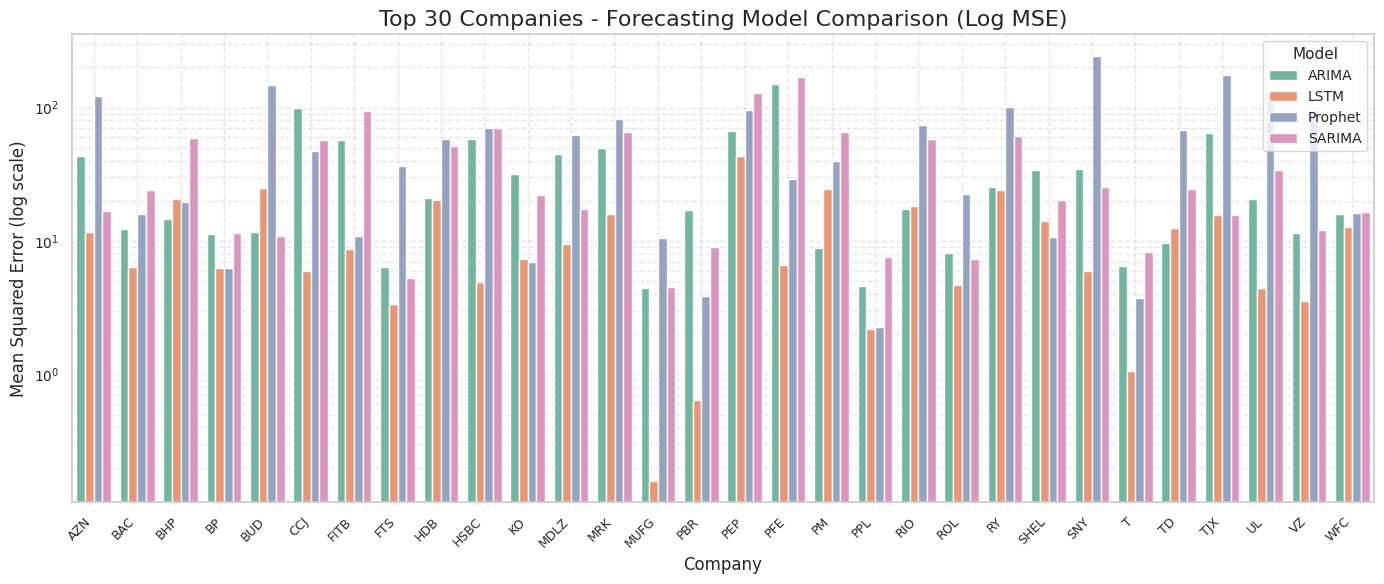

In [29]:
# STEP 8 - Combining and Visualizing the Models

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Combine results from all models
all_results = []
if 'results' in globals(): all_results += results                  # ARIMA
if 'results_sarima_statsmodels' in globals(): all_results += results_sarima_statsmodels  # SARIMA
if 'results_prophet' in globals(): all_results += results_prophet  # Prophet
if 'results_lstm' in globals(): all_results += results_lstm        # LSTM
# Create DataFrame
results_df = pd.DataFrame(all_results, columns=["Company", "Model", "MSE"])
# Keep all valid rows
results_df = results_df[results_df["MSE"].notna()]
results_df = results_df[results_df["MSE"] >= 0]
# Save all rows for export (no filtering)
results_df.to_csv("Model Comparison Results.csv", index=False)
print(f"Saved full results with {len(results_df)} rows")
# Prepare Top N subset for plotting
N = 30
top_companies = results_df.groupby("Company")["MSE"].mean().nsmallest(N).index
plot_df = results_df[results_df["Company"].isin(top_companies)]
# Sort for clean plotting
plot_df = plot_df.sort_values(by=["Company", "Model"])
# Plot
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
bar_plot = sns.barplot(
    data=plot_df,
    x="Company",
    y="MSE",
    hue="Model",
    palette="Set2",
    dodge=True
)
bar_plot.set_yscale("log")
plt.title(f"Top {N} Companies - Forecasting Model Comparison (Log MSE)", fontsize=16)
plt.xlabel("Company", fontsize=12)
plt.ylabel("Mean Squared Error (log scale)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=10)
plt.legend(title="Model", fontsize=10, title_fontsize=11, loc="upper right")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [28]:
# STEP 9 - Displaying Best Model per Company

import pandas as pd
# Make a copy so we don't overwrite original
best_results_df = results_df.copy()
# Ensure valid MSE values only
best_results_df = best_results_df[best_results_df["MSE"].notna()]
best_results_df = best_results_df[best_results_df["MSE"] > 0]
# Get the best model per company
best_models = best_results_df.loc[best_results_df.groupby("Company")["MSE"].idxmin()]
best_models = best_models.sort_values(by="MSE", ascending=True).reset_index(drop=True)
print("\nBest Model per Company")
print(best_models.to_string(index=False))
# Count wins per model
model_win_counts = best_models["Model"].value_counts().reset_index()
model_win_counts.columns = ["Model", "Win Count"]
# Add win percentage
total_companies = len(best_models)
model_win_counts["Win %"] = (model_win_counts["Win Count"] / total_companies * 100).round(2)
# Sort by most wins
model_win_counts = model_win_counts.sort_values(by="Win Count", ascending=False)
print("\nModel Win Counts")
print(model_win_counts.to_string(index=False))
# Export to CSV
best_models.to_csv("Best Model Per Company.csv", index=False)
model_win_counts.to_csv("Model Win Counts.csv", index=False)
print("\nSaved 'Best Model Per Company.csv' and 'Model Win Counts.csv'")


Best Model per Company
Company   Model           MSE
   MUFG    LSTM      0.159367
    PBR    LSTM      0.637484
      T    LSTM      1.055584
    PPL    LSTM      2.200351
    FTS    LSTM      3.398215
     VZ    LSTM      3.555692
     UL    LSTM      4.425624
    ROL    LSTM      4.644543
   HSBC    LSTM      4.909636
    CCJ    LSTM      5.963788
    SNY    LSTM      5.999827
     BP    LSTM      6.301107
    BAC    LSTM      6.405955
    PFE    LSTM      6.661418
  CMCSA    LSTM      6.738537
     KO Prophet      6.936295
   CSCO    LSTM      8.088738
   FITB    LSTM      8.738045
     PM   ARIMA      8.807704
    BMY    LSTM      8.924973
   MDLZ    LSTM      9.525912
     TD   ARIMA      9.582860
   SHEL Prophet     10.766416
    BUD  SARIMA     10.908040
    AZN    LSTM     11.747495
    WFC    LSTM     12.671615
    TTE    LSTM     14.395829
    BHP   ARIMA     14.698687
   INTC    LSTM     15.428870
    TJX    LSTM     15.580856
    MRK    LSTM     16.018940
    NVS    LSTM 

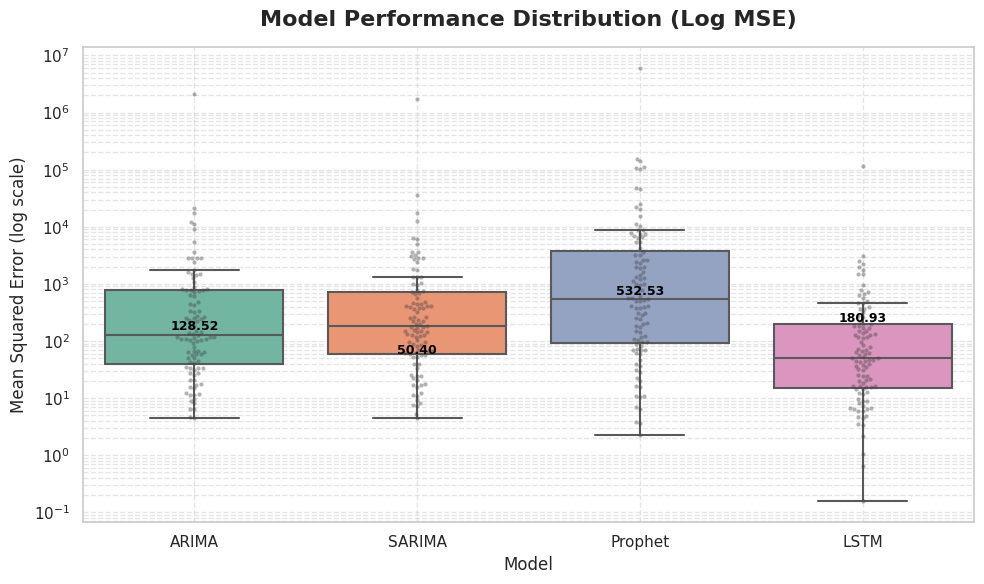

In [30]:
# STEP 10 - Boxplot of Model Performance

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
# Main boxplot
box = sns.boxplot(
    data=results_df,
    x="Model",
    y="MSE",
    palette="Set2",
    showfliers=False,
    linewidth=1.5
)
# Overlay swarmplot (slightly jittered for clarity)
sns.swarmplot(
    data=results_df,
    x="Model",
    y="MSE",
    color=".25",
    alpha=0.4,
    size=3
)
# Log scale for better MSE range visibility
plt.yscale("log")
# Title & labels
plt.title("Model Performance Distribution (Log MSE)", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Mean Squared Error (log scale)", fontsize=12)
# Annotate median values above each box
medians = results_df.groupby("Model")["MSE"].median()
for i, median in enumerate(medians):
    plt.text(
        i, median * 1.05,
        f'{median:.2f}',
        ha='center', va='bottom',
        fontsize=9, fontweight='bold', color="black"
    )
# Grid & layout
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()